In [1]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import math
import numbers
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.models as models
from torchvision import transforms, datasets
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, clear_output
import PIL
import cv2
from torchsummary import summary
import youtube_dl
import glob
import subprocess as sp
import albumentations as albu

from unet2 import UNet
from unet_parts import self_attention_conv

In [2]:
video_list = os.listdir('data')
val_set = video_list[0]
train_set = video_list[1:]

EPOCHS = 10
BATCH_SIZE = 2
LEARNING_RATE = 1e-3

G_losses = []
D_losses = []

In [3]:
unet = UNet(n_channels = 1, n_classes = 3)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.unet = unet
        
    def forward(self, x):
        x = self.unet(x)
        x = F.tanh(x)
        return x

In [4]:
COCO_dataset = datasets.ImageFolder(root='C:/Users/yliu60/Downloads/test2017',
                                    transform = transforms.Compose(
                                        [transforms.Resize((512, 512)), 
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor()]))

COCO_loader = torch.utils.data.DataLoader(COCO_dataset,
                                          batch_size = BATCH_SIZE, 
                                          num_workers = 4,
                                          shuffle = True,
                                          drop_last = True)

In [5]:
netG = Generator().cuda()
netG.train()
optimizerG = optim.Adam(netG.parameters(), lr = LEARNING_RATE)
criterion1 = nn.BCEWithLogitsLoss()
criterion2 = nn.L1Loss()

# step 1: train the generator only on feature loss

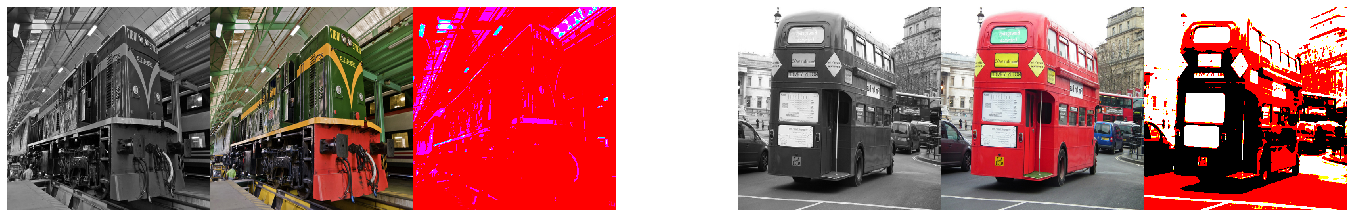

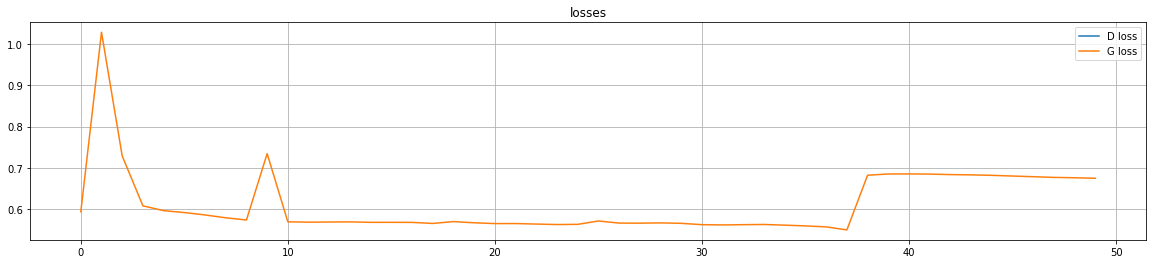

KeyboardInterrupt: 

In [8]:
step = 0
for epoch in range(EPOCHS):
    for _, imgs in enumerate(COCO_loader):
#     while(1):
        step += 1
        color_true = imgs[0]
        color_true_nparray = color_true.detach().cpu().numpy()
        color_true = color_true.cuda()
        gray_tensor = torch.zeros((BATCH_SIZE, 1, 512, 512)).cuda()
        
        for i in range(BATCH_SIZE):
            color_slice = color_true_nparray[i, ...]
            color_slice = np.transpose(color_slice, [1, 2, 0])
            gray_slice = cv2.cvtColor(color_slice, cv2.COLOR_BGR2GRAY)
            gray_tensor[i, 0, :, :] = torch.tensor(gray_slice)
            
        color_true = color_true * 2 - 1.0
        gray_tensor = gray_tensor * 2 - 1.0

        netG.zero_grad()
        color_pred = netG(gray_tensor)
        loss_G = criterion2(color_pred, color_true)
        loss_G.backward()
        G_losses.append(loss_G.item())
        optimizerG.step()

        if step % 2 == 0:
            clear_output(wait = True)

            gray = gray_tensor.detach().cpu().numpy()
            real = color_true.detach().cpu().numpy()
            fake = color_pred.detach().cpu().numpy()
            
            gray = np.squeeze(gray)
            real = np.squeeze(real)
            fake = np.squeeze(fake)
            
            r, c = BATCH_SIZE // 2, 2
            fig, axs = plt.subplots(r, c, figsize=(4 * 3 * c, 4 * r))
            cnt = 0
            for i in range(r):
                for j in range(c):
                    gray_img = gray[cnt]
                    real_img = real[cnt]
                    fake_img = fake[cnt]
                    real_img = np.transpose(real_img, [1, 2, 0])
                    fake_img = np.transpose(fake_img, [1, 2, 0])
                    gray_img = np.expand_dims(gray_img, axis = -1)
                    gray_img = np.concatenate((gray_img, gray_img, gray_img), axis = -1)
                    gray_real_fake = np.zeros((512, 512 * 3, 3))
                    gray_real_fake[:, :512, :]        = gray_img * 0.5 + 0.5
                    gray_real_fake[:, 512:(512*2), :] = real_img * 0.5 + 0.5
                    gray_real_fake[:, (512*2):, :]    = fake_img * 0.5 + 0.5
                    if (r == 1):
                        axs[j].imshow(gray_real_fake, vmin=0.0, vmax=1.0)
                        axs[j].axis('off')
                    else:
                        axs[i, j].imshow(gray_real_fake, vmin=0.0, vmax=1.0)
                        axs[i, j].axis('off')
                    cnt += 1

            plt.figure(figsize = (20, 4))
            plt.plot(D_losses, label = 'D loss')
            plt.plot(G_losses, label = 'G loss')
            plt.grid()
            plt.title('losses')
            plt.legend()

            if len(D_losses) > 5000:
                plt.figure(figsize = (20, 4))
                plt.plot(D_losses[5000:], label = 'D loss')
                plt.plot(G_losses[5000:], label = 'G loss')
                plt.grid()
                plt.title('recent losses')
                plt.legend()
                plt.show()

            plt.show()
    
    torch.save({
                'epoch': epoch,
                'model_state_dict': netG.state_dict(),
                'optimizer_state_dict': optimizerG.state_dict(),
                'loss': G_losses
                }, f'G_COCO_full_epoch_{epoch}.pth')

# step 2: train the critic using real and generated fake imgs

# step 3: train GAN loss to close realism gap

In [ ]:
EPOCHS = 10
BATCH_SIZE = 2
LEARNING_RATE = 1e-3

In [ ]:
unet = UNet(n_channels = 1, n_classes = 3)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.unet = unet
        
    def forward(self, x):
        x = self.unet(x)
        x = F.tanh(x)
        return x

In [ ]:
resnet18 = models.resnet18(pretrained = True)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size = (7, 7), stride = (2, 2), padding = (3, 3), bias = False), 
            self_attention_conv(64),
            *list(resnet18.children())[1:-1])
        self.fc = nn.Linear(512, 1)
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.fc(x)
        return x

In [ ]:
COCO_dataset = datasets.ImageFolder(root='C:/Users/yliu60/Downloads/test2017',
                                    transform = transforms.Compose(
                                        [transforms.Resize((512, 512)), 
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor()]))

COCO_loader = torch.utils.data.DataLoader(COCO_dataset,
                                          batch_size = BATCH_SIZE, 
                                          num_workers = 4,
                                          shuffle = True,
                                          drop_last = True)

In [ ]:
netG = Generator().cuda()
netD = Discriminator().cuda()

optimizerG = optim.Adam(netG.parameters(), lr = LEARNING_RATE)
optimizerD = optim.Adam(netD.parameters(), lr = LEARNING_RATE)

criterion1 = nn.BCEWithLogitsLoss()
criterion2 = nn.L1Loss()

G_losses = []
D_losses = []

checkpoint = torch.load('G_COCO_full_epoch_0.pth')
netG.load_state_dict(checkpoint['netG_state_dict'])

netG.train()
netD.train()
clear_output()

In [ ]:
step = 0
for epoch in range(EPOCHS):
    for _, imgs in enumerate(COCO_loader):
        step += 1
        color_true = imgs[0]
        color_true_nparray = color_true.detach().cpu().numpy()
        color_true = color_true.cuda()
        gray_tensor = torch.zeros((BATCH_SIZE, 1, 512, 512)).cuda()
        
        for i in range(BATCH_SIZE):
            color_slice = color_true_nparray[i, ...]
            color_slice = np.transpose(color_slice, [1, 2, 0])
            gray_slice = cv2.cvtColor(color_slice, cv2.COLOR_BGR2GRAY)
            gray_tensor[i, 0, :, :] = torch.tensor(gray_slice)
            
        color_true = color_true * 2 - 1.0
        gray_tensor = gray_tensor * 2 - 1.0
        
        # step 1, train D with real batch and fake batch
        netD.zero_grad()

        # real 
        conditional_concat = torch.cat((gray_tensor, color_true), dim = 1)
        class_pred = netD(conditional_concat)
        class_gt = torch.ones((BATCH_SIZE, 1), dtype = torch.float).cuda()
        loss_D_real = criterion1(class_pred, class_gt)

        # fake
        color_pred = netG(gray_tensor)
        conditional_concat = torch.cat((gray_tensor, color_pred), dim = 1)
        class_pred = netD(conditional_concat)
        class_gt = torch.zeros((BATCH_SIZE, 1), dtype = torch.float).cuda()
        loss_D_fake = criterion1(class_pred, class_gt)

        # together
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        D_losses.append(loss_D.item())
        optimizerD.step()

        # step 2, train G with L1 loss, GAN loss, and cycle consistency loss
        netG.zero_grad()
        color_pred = netG(gray_tensor)
        conditional_concat = torch.cat((gray_tensor, color_pred), dim = 1)
        class_pred = netD(conditional_concat)
        class_gt = torch.ones((BATCH_SIZE, 1), dtype = torch.float).cuda()
#         R = color_pred[:, 0, :, :]
#         G = color_pred[:, 1, :, :]
#         B = color_pred[:, 2, :, :]
#         color_pred_2_gray = R * 299/1000 + G * 587/1000 + B * 114/1000
        loss_G_1 = criterion1(class_pred, class_gt)
        loss_G_2 = criterion2(color_pred, color_true)
#         loss_G_3 = criterion2(color_pred_2_gray, gray_tensor)
#         loss_G = loss_G_1 + 50 * loss_G_2 + 50 * loss_G_3
        loss_G = loss_G_1 + 100 * loss_G_2
        loss_G.backward()
        G_losses.append(loss_G.item())
        optimizerG.step()

        if step % 2 == 0:
            clear_output(wait = True)

            gray = gray_tensor.detach().cpu().numpy()
            real = color_true.detach().cpu().numpy()
            fake = color_pred.detach().cpu().numpy()
            
            gray = np.squeeze(gray)
            real = np.squeeze(real)
            fake = np.squeeze(fake)
            
            r, c = BATCH_SIZE // 2, 2
            fig, axs = plt.subplots(r, c, figsize=(4 * 3 * c, 4 * r))
            cnt = 0
            for i in range(r):
                for j in range(c):
                    gray_img = gray[cnt]
                    real_img = real[cnt]
                    fake_img = fake[cnt]
                    real_img = np.transpose(real_img, [1, 2, 0])
                    fake_img = np.transpose(fake_img, [1, 2, 0])
                    gray_img = np.expand_dims(gray_img, axis = -1)
                    gray_img = np.concatenate((gray_img, gray_img, gray_img), axis = -1)
                    gray_real_fake = np.zeros((512, 512 * 3, 3))
                    gray_real_fake[:, :512, :]        = gray_img * 0.5 + 0.5
                    gray_real_fake[:, 512:(512*2), :] = real_img * 0.5 + 0.5
                    gray_real_fake[:, (512*2):, :]    = fake_img * 0.5 + 0.5
                    if (r == 1):
                        axs[j].imshow(gray_real_fake, vmin=0.0, vmax=1.0)
                        axs[j].axis('off')
                    else:
                        axs[i, j].imshow(gray_real_fake, vmin=0.0, vmax=1.0)
                        axs[i, j].axis('off')
                    cnt += 1

            plt.figure(figsize = (20, 4))
            plt.plot(D_losses, label = 'D loss')
            plt.plot(G_losses, label = 'G loss')
            plt.grid()
            plt.title('losses')
            plt.legend()

            if len(D_losses) > 5000:
                plt.figure(figsize = (20, 4))
                plt.plot(D_losses[5000:], label = 'D loss')
                plt.plot(G_losses[5000:], label = 'G loss')
                plt.grid()
                plt.title('recent losses')
                plt.legend()
                plt.show()

            plt.show()

In [ ]:
step = 0
for epoch in range(EPOCHS):
    np.random.shuffle(train_set)
    for video in train_set:
        vidcap = cv2.VideoCapture(os.path.join('data', video))
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, 10000)
        success, image = vidcap.read()
        while success:
            image = cv2.resize(image, (512, 512))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = image / 127.5 - 1.0
            gray = gray / 127.5 - 1.0
            image = np.transpose(image, [2, 0, 1])
            image = np.expand_dims(image, axis = 0)
            image_gray = np.expand_dims(gray, axis = 0)
            image_gray = np.expand_dims(image_gray, axis = 0)
            
            # step 1, train D
            netD.zero_grad()
            
            # real 
            image_gray_tensor = torch.tensor(image_gray, dtype = torch.float).cuda()
            color_true = torch.tensor(image, dtype = torch.float).cuda()
            conditional_concat = torch.cat((image_gray_tensor, color_true), dim = 1)
            class_pred = netD(conditional_concat)
            class_gt = torch.tensor([[1]], dtype = torch.float).cuda()
            loss_D_real = criterion1(class_pred, class_gt)
            
            # fake
            color_pred = netG(image_gray_tensor)
            conditional_concat = torch.cat((image_gray_tensor, color_pred), dim = 1)
            class_pred = netD(conditional_concat)
            class_gt = torch.tensor([[0]], dtype = torch.float).cuda()
            loss_D_fake = criterion1(class_pred, class_gt)
            
            loss_D = loss_D_real + loss_D_fake
            loss_D.backward()
            D_losses.append(loss_D.item())
            optimizerD.step()
            
            # step 2, train G
            netG.zero_grad()
            color_pred = netG(image_gray_tensor)
            conditional_concat = torch.cat((image_gray_tensor, color_pred), dim = 1)
            class_pred = netD(conditional_concat)
            class_gt = torch.tensor([[1]], dtype = torch.float).cuda()
            loss_G_1 = criterion1(class_pred, class_gt)
            loss_G_2 = criterion2(color_pred, color_true)
            loss_G = loss_G_1 + 5 * loss_G_2
            loss_G.backward()
            G_losses.append(loss_G.item())
            optimizerG.step()
            
            for _ in range(10):
                success, image = vidcap.read()
            
            if step % 100 == 0:
                clear_output(wait = True)
                
                real = color_true.detach().cpu().numpy()
                fake = color_pred.detach().cpu().numpy()
                real = np.squeeze(real)
                fake = np.squeeze(fake)
                real = np.transpose(real, [1, 2, 0])
                fake = np.transpose(fake, [1, 2, 0])
                gray = np.expand_dims(gray, axis = -1)
                gray = np.concatenate((gray, gray, gray), axis = -1)
                gray_real_fake = np.zeros((512, 512 * 3, 3))
                gray_real_fake[:, :512, :] = gray * 0.5 + 0.5
                gray_real_fake[:, 512:(512*2), :] = real * 0.5 + 0.5
                gray_real_fake[:, (512*2):, :] = fake * 0.5 + 0.5
                
                plt.figure(figsize = (15, 5))
                plt.imshow(gray_real_fake)
                
                plt.figure(figsize = (20, 4))
                plt.plot(D_losses, label = 'D loss')
                plt.plot(G_losses, label = 'G loss')
                plt.grid()
                plt.title('losses')
                plt.legend()
                
                if len(D_losses) > 5000:
                    plt.figure(figsize = (20, 4))
                    plt.plot(D_losses[5000:], label = 'D loss')
                    plt.plot(G_losses[5000:], label = 'G loss')
                    plt.grid()
                    plt.title('recent losses')
                    plt.legend()
                    plt.show()
                
                plt.show()

In [ ]:
def download(url):
    os.system(f"youtube-dl -f mp4 {url}")

In [ ]:
with open('movie_list.txt', 'r') as fr:
    urls = fr.readlines()
    for url in urls:
        download(url)